In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import train_test_split
import pickle

Importing data from the drive...............

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/WISDM_raw.txt', header = None, names = columns)
df = df.dropna()

Familiarizing with data....

In [0]:
df.head()

user activity       timestamp    x-axis     y-axis        z-axis
0    33  Jogging  49105962326000 -0.694638  12.680544   0.50395286;
1    33  Jogging  49106062271000  5.012288  11.264028   0.95342433;
2    33  Jogging  49106112167000  4.903325  10.882658  -0.08172209;
3    33  Jogging  49106222305000 -0.612916  18.496431    3.0237172;
4    33  Jogging  49106332290000 -1.184970  12.108489     7.205164;

In [0]:
df['z-axis'] = [(float)(str(x).split(';')[0]) for x in df['z-axis']]
df.head()

user activity       timestamp    x-axis     y-axis    z-axis
0    33  Jogging  49105962326000 -0.694638  12.680544  0.503953
1    33  Jogging  49106062271000  5.012288  11.264028  0.953424
2    33  Jogging  49106112167000  4.903325  10.882658 -0.081722
3    33  Jogging  49106222305000 -0.612916  18.496431  3.023717
4    33  Jogging  49106332290000 -1.184970  12.108489  7.205164

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098203 entries, 0 to 1098203
Data columns (total 6 columns):
user         1098203 non-null int64
activity     1098203 non-null object
timestamp    1098203 non-null int64
x-axis       1098203 non-null float64
y-axis       1098203 non-null float64
z-axis       1098203 non-null float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.7+ MB


Applying dynamic sliding window technique with window_size of 200 data points and an overlap of 10%.....

In [0]:
print(df["activity"].unique())

['Jogging' 'Walking' 'Upstairs' 'Downstairs' 'Sitting' 'Standing']


In [0]:
def plot_activity(activity, df):
    data = df[df['activity'] == activity][['x-axis', 'y-axis', 'z-axis']][:200]
    axis = data.plot(subplots=True, figsize=(6, 4), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

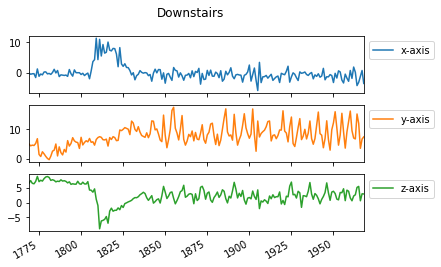

In [0]:
plot_activity("Downstairs",df)

In [0]:
TIME_STEPS = 200
N_FEATURES = 3
STEP = 20
trains = []
labels = []
for i in range(0, len(df) - TIME_STEPS, STEP):
    xT = df['x-axis'].values[i: i + TIME_STEPS]
    yT = df['y-axis'].values[i: i + TIME_STEPS]
    zT = df['z-axis'].values[i: i + TIME_STEPS]
    label = stats.mode(df['activity'][i: i + TIME_STEPS])[0][0]
    trains.append([xT, yT, zT])
    labels.append(label)

Checking the dimensions of features and labels

In [0]:
print(np.asarray(trains).shape)
print(np.asarray(labels).shape)

(54901, 3, 200)
(54901,)


Applying Onehot encoding

In [0]:
train = np.asarray(trains, dtype= np.float32).reshape(-1, TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

print(labels.shape)

(54901, 6)


Splitting datasets into test and train sets.

In [0]:
x_train, x_test, y_train, y_test = train_test_split(
        train, labels, test_size=0.2, random_state=42)

Checking for Null values in test and train sets..... if any null value exists the loss function will return Nan instead of the loss.

In [0]:
print(np.any(np.isnan(x_train)))
print(np.any(np.isnan(x_test)))

False
False


Preparing  LSTM model with 64 hidden units......

In [0]:
HIDDEN = 64
N_LABELS = 6
def LSTM_model(inputs):
  
  weights = {
      'hidden' : tf.Variable(tf.random_normal([N_FEATURES,HIDDEN])),
      'output' : tf.Variable(tf.random_normal([HIDDEN,N_LABELS]))
  }
  
  bias = {
      'hidden' : tf.Variable(tf.random_normal([HIDDEN],mean=1.0)),
      'output' : tf.Variable(tf.random_normal([N_LABELS]))
  }
  
  INPUT = tf.transpose(inputs,[1,0,2])
  INPUT = tf.reshape(INPUT,[-1,N_FEATURES])
  
  HDN = tf.nn.relu(tf.matmul(INPUT,weights['hidden'])+bias['hidden'])
  HDN = tf.split(HDN,TIME_STEPS,0)
  
  lstm_layers = [tf.contrib.rnn.BasicLSTMCell(HIDDEN,forget_bias=1.0) for _ in range(2)]
  lstm_layers = tf.contrib.rnn.MultiRNNCell(lstm_layers)
  
  outputs,_ = tf.contrib.rnn.static_rnn(lstm_layers,HDN,dtype =tf.float32)
  
  last = outputs[-1]
  
  return tf.matmul(last,weights['output'])+bias['output'] 

Creating placeholders promising that we give the inputs later...i.e is in real time....

In [0]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32,[None,TIME_STEPS,N_FEATURES],name='input')
Y = tf.placeholder(tf.float32,[None,N_LABELS])

In [0]:
y_pred = LSTM_model(X)
y_softmax= tf.nn.softmax(y_pred,name='y')

W0615 03:32:47.284327 139867697686400 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0615 03:32:47.285363 139867697686400 deprecation.py:323] From <ipython-input-11-561f1e3e6498>:21: BasicLSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0615 03:32:47.286982 139867697686400 deprecation.py:323] From <ipython-input-11-561f1e3e6498>:22: MultiRNNCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructio

loss methods

In [0]:
L2_loss = 0.0015
l2_regularization = L2_loss * sum(tf.nn.l2_loss(trainable_var) for trainable_var in tf.trainable_variables())

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y_pred,labels= Y))+l2_regularization

W0615 03:32:53.470602 139867697686400 deprecation.py:323] From <ipython-input-14-cd304d6680f2>:4: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



Giving optimizer and function for accuracy......

In [0]:
LEARNING_RATE = 0.0025

optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y_softmax,1),tf.argmax(Y,1)),tf.float32))

Training the model with 50 epochs and the for optimizing we use batch size as 1024 as the RAM runs out if the dataset is large.

In [0]:
EPOCHS = 50
BATCH = 1024
COUNT = len(x_train)

In [0]:
saver = tf.train.Saver()

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

losses = []
accuracies = []
test_losses = []
test_accuracies = []
for epoch in range(1,EPOCHS+1):
  print('EPOCH NO : ',epoch)
  for start,end in zip(range(0, COUNT, BATCH),
                          range(BATCH, COUNT + 1,BATCH)):
    
    sess.run(optimizer,feed_dict={X:x_train[start:end],Y:y_train[start:end]})
    
  _,valid_acc,valid_loss = sess.run([y_softmax,accuracy,loss],feed_dict={X:x_train,Y:y_train})
  _,test_acc,test_loss = sess.run([y_softmax,accuracy,loss],feed_dict={X:x_test,Y:y_test})
  
  losses.append(valid_loss)
  accuracies.append(valid_acc)
  test_losses.append(test_loss)
  test_accuracies.append(test_acc)
  if epoch==1 or epoch%10==0:
    
    print('EPOCH NO : ',epoch)
    print('val_acc : ',valid_acc,' val_loss',valid_loss)
    print('test_acc : ',test_acc,' test_loss',test_loss)
    
    

EPOCH NO :  1
EPOCH NO :  1
val_acc :  0.82620674  val_loss 1.1831813
test_acc :  0.8267007  test_loss 1.1828746
EPOCH NO :  2
EPOCH NO :  3
EPOCH NO :  4
EPOCH NO :  5
EPOCH NO :  6
EPOCH NO :  7
EPOCH NO :  8
EPOCH NO :  9
EPOCH NO :  10
EPOCH NO :  10
val_acc :  0.9392532  val_loss 0.5862033
test_acc :  0.935525  test_loss 0.59904474
EPOCH NO :  11
EPOCH NO :  12
EPOCH NO :  13
EPOCH NO :  14
EPOCH NO :  15
EPOCH NO :  16
EPOCH NO :  17
EPOCH NO :  18
EPOCH NO :  19
EPOCH NO :  20
EPOCH NO :  20
val_acc :  0.96020037  val_loss 0.40983632
test_acc :  0.9531919  test_loss 0.42659757
EPOCH NO :  21
EPOCH NO :  22
EPOCH NO :  23
EPOCH NO :  24
EPOCH NO :  25
EPOCH NO :  26
EPOCH NO :  27
EPOCH NO :  28
EPOCH NO :  29
EPOCH NO :  30
EPOCH NO :  30
val_acc :  0.9665528  val_loss 0.3191224
test_acc :  0.9599308  test_loss 0.33927098
EPOCH NO :  31
EPOCH NO :  32
EPOCH NO :  33
EPOCH NO :  34
EPOCH NO :  35
EPOCH NO :  36
EPOCH NO :  37
EPOCH NO :  38
EPOCH NO :  39
EPOCH NO :  40
EPOCH NO 

Saving the session in ckpt file.....

In [0]:
tf.train.write_graph(sess.graph_def,'/content/drive/My Drive/Colab Notebooks','har.pbtxt')
saver.save(sess,save_path='/content/drive/My Drive/Colab Notebooks/har.ckpt')

'/content/drive/My Drive/Colab Notebooks/har.ckpt'

Frezzing the graph : to make Pretrained model..............

In [0]:
from tensorflow.python.tools import freeze_graph

In [0]:
freeze_graph.freeze_graph('/content/drive/My Drive/Colab Notebooks/har.pbtxt',input_binary=False,input_saver="",input_checkpoint='/content/drive/My Drive/Colab Notebooks/har.ckpt',output_node_names='y',restore_op_name='save/restore_all',filename_tensor_name='save/Const:0',output_graph='freeze_model.pb',clear_devices=True,initializer_nodes="")

W0615 03:46:15.964582 139867697686400 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/tools/freeze_graph.py:127: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
W0615 03:46:25.068948 139867697686400 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/tools/freeze_graph.py:233: convert_variables_to_constants (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
W0615 03:46:25.070152 139867697686400 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/graph_util_impl.py:270: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a fut

node {
  name: "input"
  op: "Placeholder"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "shape"
    value {
      shape {
        dim {
          size: -1
        }
        dim {
          size: 200
        }
        dim {
          size: 3
        }
      }
    }
  }
}
node {
  name: "Variable"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_FLOAT
        tensor_shape {
          dim {
            size: 3
          }
          dim {
            size: 64
          }
        }
        tensor_content: "\364\231\027\276\372\340\013>\343\300L>7a\240\276\251\037\322=5\357a>\021\'y\274\326\302\005\277\033\360\231\276}\311\017\277\031\244\005?%\022\271\277\243D9?f\321\366\276xiu\277u\205\001?\375\261M?\037ZZ\276e\003\216\276\001-A\277\232uO\277\222h\237;\206\206<\276U\240r<\037\255\347\276Zb\275\276a\240D\277E\240\300=\347X\211\276e\376V>\212\371\